### Init


In [2]:
# Loading the libraries
from util import *
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [3]:
all_data = pd.read_csv(r'..\Preprocessed_datasets\preprocessed_german_credit.csv', index_col=0)
errors = all_data['errors']
features = all_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)


In [4]:
# Scaling the features 
to_scale = features.columns
features[to_scale] = StandardScaler().fit_transform(features[to_scale])
features[:5]

,Age,Job,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,...,Savings_moderate,Savings_no_inf,Savings_quite rich,Savings_rich,Check_moderate,Check_no_inf,Check_rich,Age_cat_Young,Age_cat_Adult,Age_cat_Senior
136,-0.736682,0.222911,2.097685,0.541581,1.659987,-0.077152,-0.250785,-0.547723,-0.620682,-0.109435,...,-0.323381,-0.483298,-0.276465,3.789939,-0.657422,1.249242,-0.250785,1.249242,-0.761209,-0.191859
76,-0.098692,0.222911,0.299478,1.760861,-0.602414,-0.077152,-0.250785,-0.547723,1.611131,-0.109435,...,-0.323381,-0.483298,-0.276465,-0.263857,-0.657422,-0.800485,-0.250785,1.249242,-0.761209,-0.191859
280,-1.101248,0.222911,0.068512,-0.433842,1.659987,-0.077152,-0.250785,-0.547723,-0.620682,-0.109435,...,-0.323381,-0.483298,-0.276465,3.789939,-0.657422,1.249242,-0.250785,-0.800485,-0.761209,-0.191859
319,-0.736682,-1.346756,0.174903,-0.433842,-0.602414,-0.077152,-0.250785,1.825742,-0.620682,-0.109435,...,-0.323381,-0.483298,-0.276465,-0.263857,-0.657422,-0.800485,-0.250785,1.249242,-0.761209,-0.191859
174,-0.827824,0.222911,0.086308,0.053870,-0.602414,-0.077152,3.987480,-0.547723,-0.620682,-0.109435,...,-0.323381,-0.483298,-0.276465,-0.263857,-0.657422,-0.800485,-0.250785,1.249242,-0.761209,-0.191859


### Utils

In [5]:
# TODO: experiment with differen random states, increase number of runs
clus_model_kwargs = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 2,
}


In [6]:
def plot_clusters(data):    
    scatterplot = sns.scatterplot(data=data, x="Age", y="Job", hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    plt.show()

In [7]:
def accuracy(results):
    correct = results.loc[results['errors'] == 0]
    # print('Correct:', len(correct), ' -  Total:', len(results))
    acc = len(correct)/len(results)
    # print('Accuracy:', acc)
    return acc

def bias_acc(data, cluster_id, cluster_col):
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    return accuracy(remaining_clusters) - accuracy(cluster_x)

def get_next_cluster(data):
    n_cluster = max(data['clusters'])
    highest_variance = -1
    cluster_number = 0

    for i in range(0, n_cluster):
        cluster_i = data.loc[data['clusters'] == i]
        variance_cluster = np.var(cluster_i['errors'])
        
        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            cluster_number = i
            print('--> Cluster with the highest variance:', cluster_number)

    return cluster_number

### Clustering 

In [8]:
# Combine scaled features w. class & error labels
full_data = features.copy(deep=True)
full_data['true_class'] = all_data[['true_class']]
full_data['predicted_class'] = all_data[['predicted_class']]
full_data['errors'] = all_data[['errors']]
full_data['clusters'] = 0
full_data['new_clusters'] = -1
full_data.head()

,Age,Job,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,...,Check_no_inf,Check_rich,Age_cat_Young,Age_cat_Adult,Age_cat_Senior,true_class,predicted_class,errors,clusters,new_clusters
136,-0.736682,0.222911,2.097685,0.541581,1.659987,-0.077152,-0.250785,-0.547723,-0.620682,-0.109435,...,1.249242,-0.250785,1.249242,-0.761209,-0.191859,0.0,0,0.0,0,-1
76,-0.098692,0.222911,0.299478,1.760861,-0.602414,-0.077152,-0.250785,-0.547723,1.611131,-0.109435,...,-0.800485,-0.250785,1.249242,-0.761209,-0.191859,1.0,0,1.0,0,-1
280,-1.101248,0.222911,0.068512,-0.433842,1.659987,-0.077152,-0.250785,-0.547723,-0.620682,-0.109435,...,1.249242,-0.250785,-0.800485,-0.761209,-0.191859,0.0,0,0.0,0,-1
319,-0.736682,-1.346756,0.174903,-0.433842,-0.602414,-0.077152,-0.250785,1.825742,-0.620682,-0.109435,...,-0.800485,-0.250785,1.249242,-0.761209,-0.191859,0.0,0,0.0,0,-1
174,-0.827824,0.222911,0.086308,0.053870,-0.602414,-0.077152,3.987480,-0.547723,-0.620682,-0.109435,...,-0.800485,-0.250785,1.249242,-0.761209,-0.191859,1.0,0,1.0,0,-1


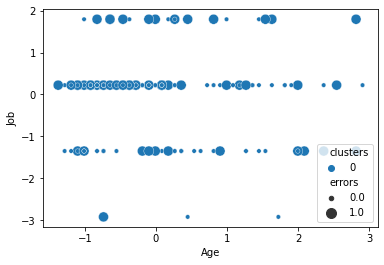

----- Clustering Iteration 1
Splitting on cluster 0


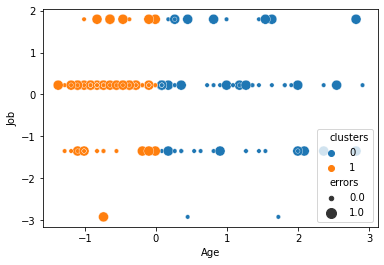

--> Cluster with the highest variance: 0
Variance clusters:  4.104353701669106e-05
----- Clustering Iteration 2
Splitting on cluster 0


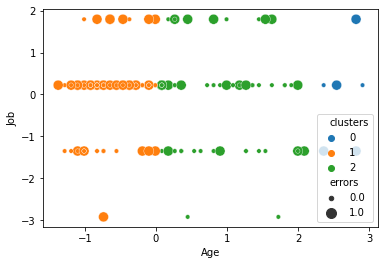

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1
Variance clusters:  0.027963595062179502
----- Clustering Iteration 3
Splitting on cluster 1


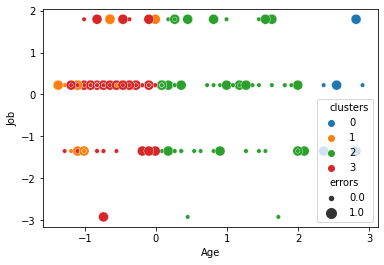

--> Cluster with the highest variance: 0
Variance clusters:  0.025022940883494056
----- Clustering Iteration 4
Splitting on cluster 0
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.025022940883494056
----- Clustering Iteration 5
Splitting on cluster 3


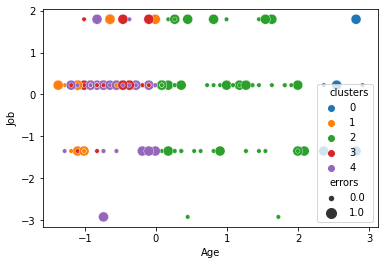

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 3
Variance clusters:  0.020569008819843936
----- Clustering Iteration 6
Splitting on cluster 3


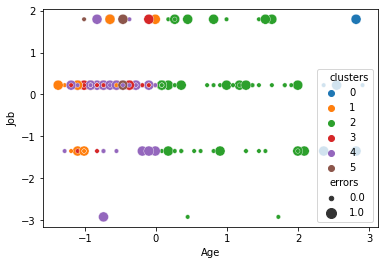

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 4
Variance clusters:  0.02296154903067839
----- Clustering Iteration 7
Splitting on cluster 4


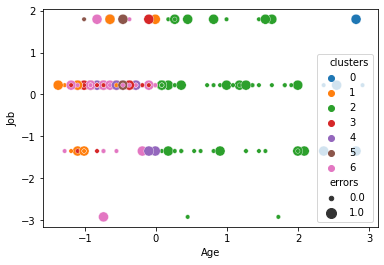

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 5
Variance clusters:  0.051474008130975156
----- Clustering Iteration 8
Splitting on cluster 5
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.051474008130975156
----- Clustering Iteration 9
Splitting on cluster 0
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.051474008130975156
----- Clustering Iteration 10
Splitting on cluster 6


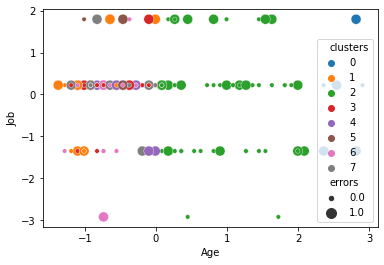

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 5
Variance clusters:  0.055228732642833456
----- Clustering Iteration 11
Splitting on cluster 5
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.055228732642833456
----- Clustering Iteration 12
Splitting on cluster 1
Initial bias: 0.06695402298850583   -  Max abs. candidate bias: 0.35119047619047616
Min candidate size: 1
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.055228732642833456
----- Clustering Iteration 13
Splitting on cluster 5
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.055228732642833456
----- Clustering Iteration 14
Splitting on cluster 6


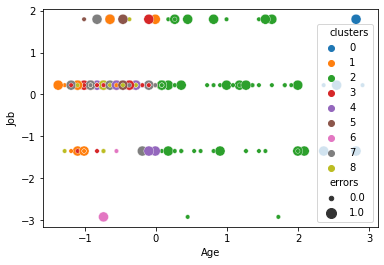

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 5
Variance clusters:  0.059454043148784344
----- Clustering Iteration 15
Splitting on cluster 5
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.059454043148784344
----- Clustering Iteration 16
Splitting on cluster 8


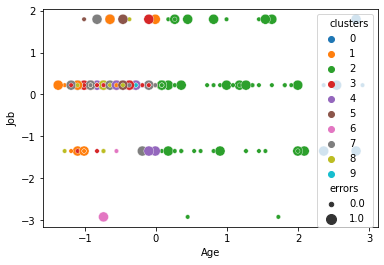

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 5
Variance clusters:  0.058273011917261267
----- Clustering Iteration 17
Splitting on cluster 5
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.058273011917261267
----- Clustering Iteration 18
Splitting on cluster 8
Initial bias: 0.2761795166858457   -  Max abs. candidate bias: 0.35119047619047616
Min candidate size: 1
The selected cluster is not splitted. Picking a random cluster...
Variance clusters:  0.058273011917261267
----- Clustering Iteration 19
Splitting on cluster 2


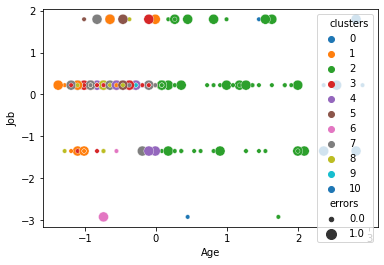

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 5
--> Cluster with the highest variance: 9
MAX_ITER
[4.104353701669106e-05, 0.027963595062179502, 0.025022940883494056, 0.025022940883494056, 0.020569008819843936, 0.02296154903067839, 0.051474008130975156, 0.051474008130975156, 0.051474008130975156, 0.055228732642833456, 0.055228732642833456, 0.055228732642833456, 0.055228732642833456, 0.059454043148784344, 0.059454043148784344, 0.058273011917261267, 0.058273011917261267, 0.058273011917261267]


In [9]:
MAX_ITER = 20
x = 0 # cluster number
initial_bias = 0
plot_clusters(full_data)
variance_list = []

for i in range(1, MAX_ITER):
    if i != 1:
        neg_bias_list = []
        for j in full_data['clusters'].unique():
            neg_bias_clus = bias_acc(full_data, j, 'clusters')
            neg_bias_list.append(neg_bias_clus)
        variance_clusters = np.var(neg_bias_list)
        variance_list.append(variance_clusters)
        print('Variance clusters: ', variance_clusters)
    print('----- Clustering Iteration', i)
    print('Splitting on cluster', x)

    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 
    #print(candidate_cluster.head())

    if len(candidate_cluster) < 8:
        print('The selected cluster is not splitted. Picking a random cluster...')
        n_cluster = max(full_data['clusters'])
        x = random.randint(0, n_cluster)
        initial_bias = abs(bias_acc(full_data, x, 'clusters'))
        continue
    
    # Apply Kmeans 
    kmeans_algo = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)),index=candidate_cluster.index) 
    # print(candidate_cluster.head())

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])
    # print(full_data.head())
        
    # calculate bias & cluster size for each of the two clusters
    negative_bias_0 = bias_acc(full_data, 0, 'new_clusters')
    negative_bias_1 = bias_acc(full_data, 1, 'new_clusters') 
    max_abs_bias = max(abs(negative_bias_0), abs(negative_bias_1))
    min_new_size = min( len(full_data.loc[full_data['new_clusters']==0]), len(full_data.loc[full_data['new_clusters']==1]) )
    
    if (max_abs_bias >= initial_bias) & (min_new_size > 1): 
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        #print(full_data.head())
        
        plot_clusters(full_data)

        x = get_next_cluster(full_data)
        initial_bias = abs(bias_acc(full_data, x, 'clusters'))
    else:
        print('Initial bias:', initial_bias, '  -  Max abs. candidate bias:', max_abs_bias)
        print('Min candidate size:', min_new_size)
        print('The selected cluster is not splitted. Picking a random cluster...')
        n_cluster = max(full_data['clusters'])
        x = random.randint(0, n_cluster)
        initial_bias = abs(bias_acc(full_data, x, 'clusters'))
        
print('MAX_ITER')

print(variance_list)

,variance
0,0.000041
1,0.027964
2,0.025023
3,0.025023
4,0.020569
5,0.022962
6,0.051474
7,0.051474
8,0.051474
9,0.055229


<AxesSubplot:ylabel='variance'>

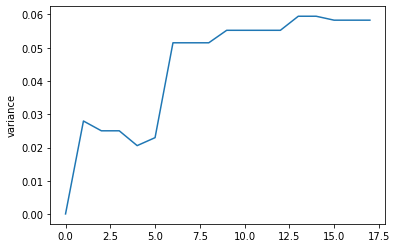

In [10]:
variance_df = pd.DataFrame(variance_list).rename(columns={0:"variance"})
display(variance_df)
sns.lineplot(data=variance_df, x=variance_df.index,y="variance")

In [10]:
# exporting the biased cluster dataframe for further analysis
import os
# path = r'..\\Clustered_datasets\\'
# full_data.to_csv(os.path.join(path, r'biased_credit_clusters.csv'))
